In [1]:
# import all dependencies
import pandas as pd
import requests
import json
import scipy.stats as st
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas

# store and import any api keys needed
from angie_config import geoapify_key

# turn off warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
# read health data from csv
health_df = pd.read_csv('obesity_diabetes_csv.csv')



In [3]:
# revise csv to show only needed columns
health_df = health_df[['Year', 'LocationName', 'Data_Value', 'Geolocation', 'Short_Question_Text']]

# split geolocation column into long/lat columns
health_df[['point','Longitude', 'Latitude']] = health_df['Geolocation'].str.split(' ', expand=True)

#clean up new long/lat columns
health_df['Longitude'] = health_df['Longitude'].str.replace("(", "")
health_df['Latitude'] = health_df['Latitude'].str.replace(")", "")

health_df.head()




,Year,LocationName,Data_Value,Geolocation,Short_Question_Text,point,Longitude,Latitude
0,2021,73002,13.1,POINT (-97.73097606 34.94935021),Diabetes,POINT,-97.73097606,34.94935021
1,2021,73002,40.6,POINT (-97.73097606 34.94935021),Obesity,POINT,-97.73097606,34.94935021
2,2021,73003,8.9,POINT (-97.49717346 35.66897845),Diabetes,POINT,-97.49717346,35.66897845
3,2021,73003,34.4,POINT (-97.49717346 35.66897845),Obesity,POINT,-97.49717346,35.66897845
4,2021,73004,10.2,POINT (-97.905542 35.13636931),Diabetes,POINT,-97.905542,35.13636931


In [4]:
# Clean up! Delete unnecessary columns, rename columns for useability, and reorder columns
health_df = health_df.drop(['Geolocation', 'point'], axis=1)

In [5]:
# Rename columns for useability
health_df = health_df.rename(columns={"LocationName":"zip_code", "Short_Question_Text":"Indicator"})

health_df.head()




,Year,zip_code,Data_Value,Indicator,Longitude,Latitude
0,2021,73002,13.1,Diabetes,-97.73097606,34.94935021
1,2021,73002,40.6,Obesity,-97.73097606,34.94935021
2,2021,73003,8.9,Diabetes,-97.49717346,35.66897845
3,2021,73003,34.4,Obesity,-97.49717346,35.66897845
4,2021,73004,10.2,Diabetes,-97.905542,35.13636931


In [6]:
# Group decision- focus on obesity only, so pull obesity only from dataframe

obesity_df = pd.DataFrame(health_df.loc[health_df['Indicator'] == "Obesity", :])

obesity_df.head()




,Year,zip_code,Data_Value,Indicator,Longitude,Latitude
1,2021,73002,40.6,Obesity,-97.73097606,34.94935021
3,2021,73003,34.4,Obesity,-97.49717346,35.66897845
5,2021,73004,37.9,Obesity,-97.905542,35.13636931
7,2021,73005,45.0,Obesity,-98.23818097,35.05783297
9,2021,73006,43.1,Obesity,-98.40269923,34.90892372


In [7]:
# TEST BOX- Pull grocery stores for a single location to check data

latitude = 36.11893133
longitude = -95.806359
zipcode = 74134

categories = "commercial.supermarket"
radius = 8000

filters = f"circle:{longitude},{latitude},{radius}"


params = {
    "categories":categories,
    "filter":filters,
    "apiKey":geoapify_key
    
}


base_url = "https://api.geoapify.com/v2/places"

response = requests.get(base_url, params=params)

grocery_data = response.json()
print(json.dumps(grocery_data, indent=4, sort_keys=True))


{
    "features": [
        {
            "geometry": {
                "coordinates": [
                    -95.77579920672153,
                    36.07625146375778
                ],
                "type": "Point"
            },
            "properties": {
                "address_line1": "Walmart Neighborhood Market",
                "address_line2": "1300 East Albany Street, Broken Arrow, OK 74012, United States of America",
                "categories": [
                    "building",
                    "building.commercial",
                    "commercial",
                    "commercial.supermarket",
                    "wheelchair",
                    "wheelchair.yes"
                ],
                "city": "Broken Arrow",
                "country": "United States",
                "country_code": "us",
                "county": "Tulsa County",
                "datasource": {
                    "attribution": "\u00a9 OpenStreetMap contributors",
                    

In [8]:


#add blank column to store count of grocery stores
obesity_df["Store Count"] = ""

obesity_df.head()




,Year,zip_code,Data_Value,Indicator,Longitude,Latitude,Store Count
1,2021,73002,40.6,Obesity,-97.73097606,34.94935021,
3,2021,73003,34.4,Obesity,-97.49717346,35.66897845,
5,2021,73004,37.9,Obesity,-97.905542,35.13636931,
7,2021,73005,45.0,Obesity,-98.23818097,35.05783297,
9,2021,73006,43.1,Obesity,-98.40269923,34.90892372,


In [9]:
#NOTE: this takes 8-10 minutes to run

#use dataframe to find grocery stores within 5 miles (about 8000 m)

# set parameters
radius = 8000

categories = "commercial.supermarket"

params = {
    "categories":categories,
    "apiKey":geoapify_key
}


for index, row in obesity_df.iterrows():
    #get lat and long
    latitude = obesity_df.loc[index, "Latitude"]
    longitude = obesity_df.loc[index, "Longitude"]
    
    #add filter & bias params with lat/long to params dictionary
    params["filter"] = f"circle:{longitude},{latitude},{radius}"
    params["bias"] = f"proximity:{longitude},{latitude}"
    
    #set base url
    base_url = "https://api.geoapify.com/v2/places"
    
    #make request using params dictionary
    grocery_stores = requests.get(base_url, params=params)
    
    #convert to json
    grocery_stores = grocery_stores.json()
    
    #append list
    obesity_df.loc[index, "Store Count"] = (len(grocery_stores["features"]))

    

In [10]:
# display sample of new DF
obesity_df.head()


,Year,zip_code,Data_Value,Indicator,Longitude,Latitude,Store Count
1,2021,73002,40.6,Obesity,-97.73097606,34.94935021,0
3,2021,73003,34.4,Obesity,-97.49717346,35.66897845,12
5,2021,73004,37.9,Obesity,-97.905542,35.13636931,0
7,2021,73005,45.0,Obesity,-98.23818097,35.05783297,1
9,2021,73006,43.1,Obesity,-98.40269923,34.90892372,0


In [11]:
# check dtypes!
obesity_df.dtypes


Year             int64
zip_code         int64
Data_Value     float64
Indicator       object
Longitude       object
Latitude        object
Store Count     object
dtype: object

In [12]:
# change long/lat/store count to float
obesity_df["Latitude"] = obesity_df["Latitude"].astype(float)
obesity_df["Longitude"] = obesity_df["Longitude"].astype(float)
obesity_df["Store Count"] = obesity_df["Store Count"].astype(float)

obesity_df.head()


,Year,zip_code,Data_Value,Indicator,Longitude,Latitude,Store Count
1,2021,73002,40.6,Obesity,-97.730976,34.949350,0.0
3,2021,73003,34.4,Obesity,-97.497173,35.668978,12.0
5,2021,73004,37.9,Obesity,-97.905542,35.136369,0.0
7,2021,73005,45.0,Obesity,-98.238181,35.057833,1.0
9,2021,73006,43.1,Obesity,-98.402699,34.908924,0.0


In [13]:
obesity_df.dtypes

Year             int64
zip_code         int64
Data_Value     float64
Indicator       object
Longitude      float64
Latitude       float64
Store Count    float64
dtype: object

In [15]:
# export clean data frame to csv file
obesity_df.to_csv("output/store_count.csv") # need to enter file path here

In [17]:
# test- try the summary stats below with a "group by" to capture each store count separately?

summary_stores = obesity_df.groupby(["Store Count"])["Data_Value"].agg(['mean', 'median', 'var', 'std', 'sem'])

summary_stores


,mean,median,var,std,sem
Store Count,,,,,
0.0,41.345909,41.60,6.354653,2.520844,0.120177
1.0,41.987879,41.80,6.240159,2.498031,0.307486
2.0,41.211765,41.30,4.704100,2.168894,0.371962
3.0,39.222222,39.70,8.619444,2.935889,0.978630
4.0,41.385714,43.30,21.864762,4.675977,1.767353
5.0,39.440000,40.65,37.269333,6.104861,1.930527
6.0,37.225000,36.05,30.842500,5.553602,2.776801
7.0,35.825000,34.20,23.409167,4.838302,2.419151
8.0,38.900000,38.90,NaN,NaN,NaN


In [18]:
#run some stats- find mean, med, var, std, sem for store count and for obesity rate (data_value)
summary_stores = obesity_df["Store Count"].agg(['mean', 'median', 'var', 'std', 'sem'])

summary_stores


mean       2.121495
median     0.000000
var       25.292548
std        5.029170
sem        0.198485
Name: Store Count, dtype: float64

In [19]:
#run stats for obesity rate
summary_obesity = obesity_df["Data_Value"].agg(['mean', 'median', 'var', 'std', 'sem'])

summary_obesity


mean      40.887072
median    41.300000
var       10.294981
std        3.208579
sem        0.126633
Name: Data_Value, dtype: float64

In [24]:
# maps- grocery store count
grocery_map = obesity_df.hvplot.points(
    'Longitude', 
    'Latitude', 
    geo = True, 
    tiles = "OSM", 
    frame_width = 600,
    frame_height = 400,
    scale = 1.75,
    size = 'Store Count',
    color = 'Data_Value',
    hover_cols = ['zip_code', 'Store Count'],
    title = 'Grocery Store Count vs. Obesity Rate')

grocery_map



:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Data_Value,Store Count,zip_code)

In [26]:
# maps- obesity count
obesity_map = obesity_df.hvplot.points("Longitude", "Latitude", geo = True, tiles = "OSM", size = "Data_Value",
                                      color = 'Data_Value', hover_cols = ['zip_code', 'Data_Value'], title = 'Obesity Rates by Zip Code')

obesity_map


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Data_Value,zip_code)

In [28]:
# scatter plots and linear regressions
# define a function for reg plots to use for obesity

def reg_plot():
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x_values,y_values)
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,(100, 100),xycoords='figure pixels',fontsize=15,color="red")
    plt.xlabel('Store Count (<= 5 mi)') #this will stay the same for all plotsd, keep in code
    plt.ylabel(y_label) #this will change for each north/south set, so the variable will be defined before the function is run
    print(f"The r-squared is: {rvalue**2}")
    plt.show()



The r-squared is: 0.13769529889860466


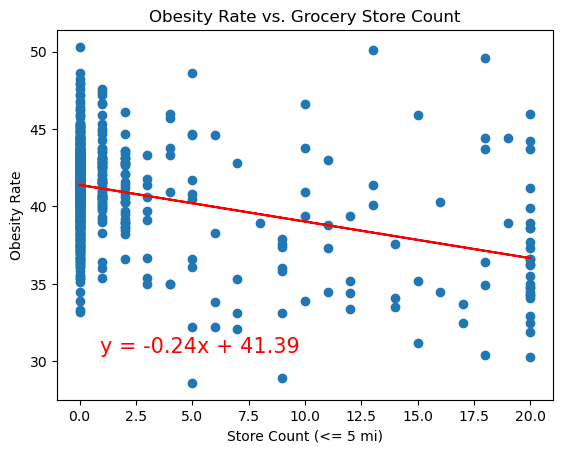

<Figure size 640x480 with 0 Axes>

In [30]:
#linear regression- obesity
x_values = obesity_df['Store Count']
y_values = obesity_df['Data_Value']
y_label =  "Obesity Rate"
plt.title('Obesity Rate vs. Grocery Store Count')

reg_plot()
plt.savefig("output/store_count_obesity_linear_regression.png")


In [31]:
#obesity hypothesis testing: t-test

#find min/max of store count (this will be the same for diabetes)
min_val = obesity_df["Store Count"].min()
max_val = obesity_df["Store Count"].max()

print(f"Store counts range from {min_val} to {max_val}")



Store counts range from 0.0 to 20.0


In [32]:
#set groups
group0 = obesity_df[obesity_df["Store Count"] == 0]["Data_Value"]
group1 = obesity_df[obesity_df["Store Count"] == 1]["Data_Value"]
group2 = obesity_df[obesity_df["Store Count"] == 2]["Data_Value"]
group3 = obesity_df[obesity_df["Store Count"] == 3]["Data_Value"]
group4 = obesity_df[obesity_df["Store Count"] == 4]["Data_Value"]
group5 = obesity_df[obesity_df["Store Count"] == 5]["Data_Value"]
group6 = obesity_df[obesity_df["Store Count"] == 6]["Data_Value"]
group7 = obesity_df[obesity_df["Store Count"] == 7]["Data_Value"]
group8 = obesity_df[obesity_df["Store Count"] == 8]["Data_Value"]
group9 = obesity_df[obesity_df["Store Count"] == 9]["Data_Value"]
group10 = obesity_df[obesity_df["Store Count"] == 10]["Data_Value"]
group11 = obesity_df[obesity_df["Store Count"] == 11]["Data_Value"]
group12 = obesity_df[obesity_df["Store Count"] == 12]["Data_Value"]
group13 = obesity_df[obesity_df["Store Count"] == 13]["Data_Value"]
group14 = obesity_df[obesity_df["Store Count"] == 14]["Data_Value"]
group15 = obesity_df[obesity_df["Store Count"] == 15]["Data_Value"]
group16 = obesity_df[obesity_df["Store Count"] == 16]["Data_Value"]
group17 = obesity_df[obesity_df["Store Count"] == 17]["Data_Value"]
group18 = obesity_df[obesity_df["Store Count"] == 18]["Data_Value"]
group19 = obesity_df[obesity_df["Store Count"] == 19]["Data_Value"]
group20 = obesity_df[obesity_df["Store Count"] == 20]["Data_Value"]

#perform ANOVA
st.f_oneway(group0, group1, group2, group3, group4, group5, group6, group7, group8, group9,
           group10, group11, group12, group13, group14, group15, group16, group17, group18, group19, group20)


F_onewayResult(statistic=9.103070262508231, pvalue=3.2008076352896274e-24)

Text(0.5, 0, 'Obesity Rate')

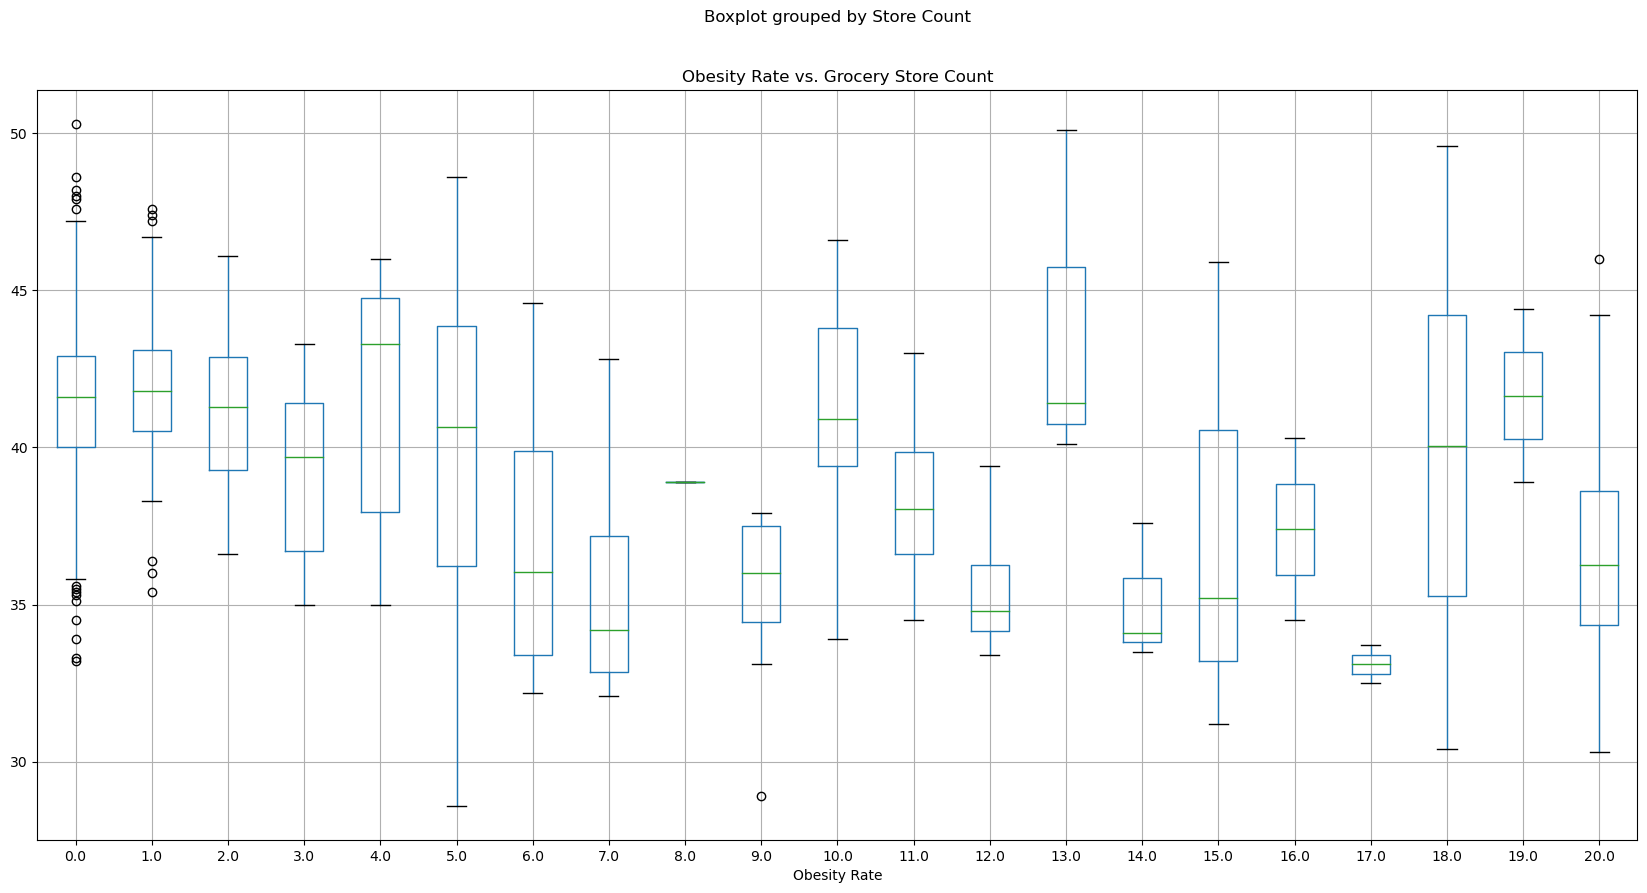

In [34]:
obesity_df.boxplot("Data_Value", by="Store Count", figsize = (20,10))
plt.title('Obesity Rate vs. Grocery Store Count')
plt.xlabel('Obesity Rate')

In [35]:
# export box plot as jpg
plt.savefig("output/box_store_count.png")


<Figure size 640x480 with 0 Axes>